### Imports and Setup

In [29]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

from modAL.models import BayesianOptimizer, ActiveLearner, CommitteeRegressor
from modAL.acquisition import max_EI
from modAL.disagreement import max_std_sampling
from modAL.uncertainty import uncertainty_sampling

from scipy import sparse

# import seqlogo

import copy

### Set random seed
seed = 5
random.seed(seed)
np.random.seed(seed)

### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

# 1.1. Data Load (5 points)
**In this question, you need to build a regression model with active learning for predicting binding affinity between MHC class I and small peptides. The dataset is provided in file `hw3_data.csv`.**

**TODO**
- **Read the data into the jupyter notebook. Columns 2 and 3 in the dataset file correspond to peptide sequences and pIC50 values.**

### Load Data

In [2]:
data = pd.read_csv('data/hw3_data.csv', delimiter=',',header=0)
print(data.shape)
data.head(5)

(9051, 4)


,id,allele,seq,pIC50
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0
1,seq1,HLA-A*02:01,AIYDTMQYV,9.0
2,seq2,HLA-A*02:01,ALATFTVNI,9.0
3,seq3,HLA-A*02:01,ALDEGLLPV,9.0
4,seq4,HLA-A*02:01,ALFPIIWAL,9.0


# 1.2. Encode Data (10 points)
**Since we are dealing with machine learning models, you need to convert peptide sequences into feature vectors. The simplest way to do this is to use a one-hot encoding.**

**Each character in the amino acid alphabet will correspond to a binary vector with a single 1 and all zeros. The size of the vector is equal to the size of the amino acid alphabet. The position of 1 encodes a specific amino acid. The resulting feature vector for a peptide is a concatenation of the feature vectors of its amino acids. Since we are dealing with 9-mers here, the size of the feature vector for a peptide should be equal to 9*(size of the amino acid alphabet).**

**TODO**
- **Encode the data.**
- **Split data into train and test datasets.**

### Encode Data
I want to keep some notion of the order of the amino acids. The 3D structure they form is vital for predicting binding quality. One possible way is to group letters in order. How do I decide how many letters constitutes a group?

Ex: 3-mers
```
AIIDYIAYM
AII
 IID
  IDY
    ...
      AYM
```

3-mers results in N < J, where N is the number of samples and J is the number of features. If we want to use multivariate regression, we'll need to use ridge regression or some other sparse form.

In [3]:
data['seq'].str.len().unique()  # every seq is length 9

array([9])

In [4]:
# create separate columns for each amino acid
for i in range(9):
    colname='seq'+str(i)
    data[colname] = [x[i] for x in data['seq']]

In [5]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [6]:
# number of unique letters
len(data['seq0'].unique())

20

In [7]:
# # create triplets
# k = 3
# count = 9-k+1
# start=0
# end=k
# for i in range(count):
#     colname='triplet'+str(i)
#     data[colname] = [x[start:end] for x in data['seq']]
#     start +=1
#     end +=1

In [8]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [9]:
X_df = data.drop(['pIC50','id','allele', 'seq'],axis=1)
y = data['pIC50']
print(X_df.shape)
print(y.shape)

(9051, 9)
(9051,)


In [10]:
X_df.head(1)

,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,A,I,I,D,Y,I,A,Y,M


In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X_df)
print(type(X_enc))
print(X_enc.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(9051, 180)


In [12]:
# convert to numpy array
X_np=sparse.csr_matrix.toarray(X_enc)
print(type(X_np))
print(X_np.shape)
y_np = y.to_numpy()
print(y_np.shape)

<class 'numpy.ndarray'>
(9051, 180)
(9051,)


### Split Data

In [13]:
#?? initial training set for active learners?
n_initial = 10

# select random instances to use as initial active learning training set
idx_initial = np.random.choice(X_np.shape[0], n_initial)
X_initial = X_np[idx_initial]
y_initial = y_np[idx_initial]
print(X_initial.shape)
print(y_initial.shape)


# remove from pool of data for testing and training
X_pool = np.delete(X_np, idx_initial, axis=0)
y_pool = np.delete(y_np, idx_initial, axis=0)
print(X_pool.shape)
print(y_pool.shape)


# split remaining pool of data
X_train, X_test, y_train, y_test = train_test_split(X_pool, y_pool, test_size=0.33)
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(10, 180)
(10,)
(9041, 180)
(9041,)

(6057, 180)
(6057,)
(2984, 180)
(2984,)


### Experiment with offline learners

In [14]:
%%time

# train RFC model on entire pool of data
rf = RandomForestRegressor(n_estimators = 20, 
                            max_depth = 6, 
                            random_state = seed)
rf.fit(X_train, y_train)

# calculate accuracy
print(rf.score(X_test,y_test))  # uses R^2

0.473993532048129
CPU times: user 361 ms, sys: 6.12 ms, total: 367 ms
Wall time: 373 ms


In [15]:
%%time

clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

print(clf.score(X_test,y_test))  # uses R^2

0.6346950488738093
CPU times: user 34.4 ms, sys: 6.03 ms, total: 40.4 ms
Wall time: 17.2 ms


In [16]:
# %%time
# # 12 minutes for (5931,180)

# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# gpr = GaussianProcessRegressor(kernel,random_state=seed)
# gpr.fit(X_train, y_train)
# print(gpr.score(X_test,y_test)) #0.69 score

# 1.3. Build Active Learning  model (20 points)
**Now you can start building the model with active learning! We do not give you any specific instructions as to which algorithm to implement. You can use something similar to [this](https://modal-python.readthedocs.io/en/latest/content/examples/active_regression.html) example in modAL documentation, or query-by-committee when a label is requested for samples which the committee is least confident about or anything else covered in the lectures.**

**TODO**
- **Implement an active learning algorithm using modAL.**

In [37]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [45]:

# initialize regressor with sample
# n_initial = 5
# initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
# X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std#,
#     X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X_train)
    print(query_idx)
    regressor.teach(X_train[query_idx].reshape(1, -1), y_train[query_idx].reshape(1, -1))
    
    # remove queried point from pool
    

y_pred_final = regressor.predict(X_test, return_std=False)
y_train_pred = regressor.predict(X_train, return_std=False)


r2=r2_score(y_test,y_pred_final)
r2_train=r2_score(y_train,y_train_pred)


# print(y_test,y_pred_final,y_train_pred)
print("R2",r2,r2_train)   


0
2
4
9
10
43
108
194
1532
1923
R2 -3.2307088256976604 -3.2750007638272525


In [18]:
def get_next_sample(learner, X, y):
    '''
    Queries the pool X of data and selects a new sample 
    using the query_strategy of the ActiveLearner.
    
    Args:
        learner: the ActiveLearner within which a 
        query_strategy is defined.
    
        X: the pool of data from which to select a sample.
        This is a numpy array of feature instances.
    
        y: the pool of labels corresponding to X instances.
        This is a numpy array of labels. 
        
    Returns:
        (X,y,idx) tuple of the selected sample, where idx 
        is the index of the selected sample.
    '''
    
    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = learner.query(X)
    
    # modify indexing to interpret as collection of one element with d features
    query_sample_reshaped = query_sample.reshape(1,-1)
   
    # obtain the query label
    query_label = y[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1,)
    
    return query_sample_reshaped, query_label_reshaped, query_idx

In [19]:
def run_active_learner(learner, X_pool, y_pool, X_test, y_test, num_queries):
    '''
    Performs active learning using given ActiveLearner. Runs for 
    the given number of queries. Each iteration draws from the pool of 
    data using the learner's query_strategy, updates the model, 
    then scores the model against given test data. 
    
    Args:   
        learner: the ActiveLearner
    
        X_pool: the pool of feature data from which to sample
    
        y_pool: the labels corresponding to the X_pool
    
        X_test: the collection of data with which to score 
        the model
    
        y_test: the labels corresponding to the X_test
    
        num_queries: the number of queries (iterations) to 
        execute during active learning.
     
     
    Returns:
        List of scores, in query order, starting with a score 
        representing the model before any queries.
    '''
    history = [] # score history
    
    # score model before active learning starts
    y_pred = learner.predict(X_test)
    history.append(r2_score(y_test,y_pred))

    # perform active learning
    for idx in range(num_queries):

        # get sample
        X_sample, y_sample, query_idx = get_next_sample(learner, X_pool, y_pool)

        # use new sample to update the model
        learner.teach(X_sample, y_sample)

        # score against test data
        y_pred = learner.predict(X_test)
        history.append(r2_score(y_test,y_pred))
        
        # remove labeled instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
    return history

In [17]:
# https://modal-python.readthedocs.io/en/latest/content/examples/ensemble_regression.html

In [20]:
# # build a committee using bootstrapping
# n_committee = 10

# learner_list = []
# n_initial=10
# for i in range(n_committee):

#     # bootstrap sample
#     idx = np.random.choice(n_initial, X_initial.shape[0])
#     X_boot = X_initial[idx]
#     y_boot = y_initial[idx]

#     #     learner_1 = ActiveLearner(
#     #         estimator=Ridge(alpha=1.0),
#     #         X_training=X_boot, 
#     #         y_training=y_boot
#     #     )

#     #     learner_2 = ActiveLearner(
#     #         estimator=RandomForestRegressor(n_estimators=20,max_depth=6,random_state=seed),
#     #         X_training=X_boot, 
#     #         y_training=y_boot
#     #     )

# #     kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
#     kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    
#     learner = ActiveLearner(
#         estimator=GaussianProcessRegressor(kernel),
#         X_training=X_boot, 
#         y_training=y_boot
#     )

#     learner_list.append(learner)
# #     learner_list.append(learner_2)


In [21]:
# %%time
# # 7 min for 100 queries

# # copy data for use with this section
# X_pool_comm = copy.deepcopy(X_train)
# y_pool_comm = copy.deepcopy(y_train)


# # define Committee
# # initializing the Committee
# committee = CommitteeRegressor(
#     learner_list=learner_list,
#     query_strategy=max_std_sampling
# )

# # run active learner and obtain score history
# n_queries = 10
# history_comm = run_active_learner(committee,X_pool_comm, y_pool_comm, X_test, y_test, n_queries)

CPU times: user 7min 33s, sys: 4.24 s, total: 7min 37s
Wall time: 1min 55s


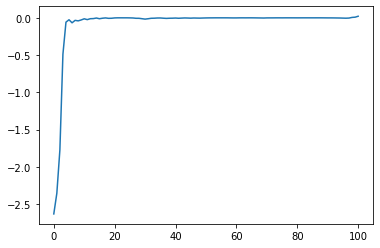

In [22]:
# plt.plot(history_comm)

# 1.4. Score model (5 points)
**The quality of the model should be measured on the test set as $R^2$ score. The minimum acceptable $R^2$ score is 0.6.**

**TODO**
- **Score the model on the test set using $R^2$.**

# 1.5. Compare with Offline Learner (5 points)
**TODO**
- **Compare your results with no active learning scheme by training a random forest classifier on the same amount of data points, but selected randomly.**

In [25]:
#?? regressor not classifier

# copy data for this section
X_pool_rand = copy.deepcopy(X_train)
y_pool_rand = copy.deepcopy(y_train)

history_rand=[]
for t in range(1,n_queries):
    
    # get random data points
    query_idx = np.random.choice(t, X_pool_rand.shape[0])    
    
    # train model
    rfr = RandomForestRegressor(n_estimators=20,max_depth=6,random_state=seed)
    rfr.fit(X_pool_rand[query_idx],y_pool_rand[query_idx])
    
    # score model
    score = rfr.score(X_test,y_test)
    history_rand.append(score)

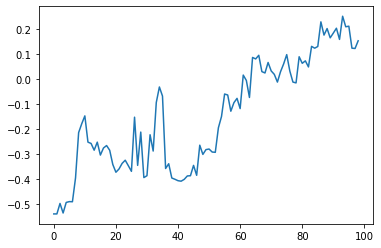

In [26]:
plt.plot(history_rand)

# 1.6. Summary (5 points)
**TODO**
- **Write a paragraph about your method, describe your observations and difficulties.**

In [ ]:
#?? ask about this block

### TO DO
### please edit this block, and feel free to remove any code we provided for you.

# regressor = ActiveLearner(
#     X_training=X_train[0].reshape(1, -1), y_training=y_train[0].reshape(1, -1)     #??
# )


# n_queries = 200
# for idx in range(n_queries):
    
#     query_idx = np.random.randint(len(X_train))
    
#     # improve model
#     regressor.teach(X_train[query_idx].reshape(1,-1), y_train[query_idx].reshape(1,-1))
    
#     # delete queried from pool
#     X_train, y_train = (np.delete(X_train, query_idx, axis=0), np.delete(y_train, query_idx))
    


    

# y_pred_final = regressor.predict(X_test, return_std=False)
# y_train_pred = regressor.predict(X_train, return_std=False)


# r2=r2_score(y_test,y_pred_final)
# r2_train=r2_score(y_train,y_train_pred)


# print(y_test,y_pred_final,y_train_pred)
# print("R2",r2,r2_train)